In [1]:
from collections import defaultdict, Counter
from copy import deepcopy
from datetime import datetime
import itertools
import warnings
warnings.simplefilter("ignore")

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.stats.multitest as multitest
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
import xgboost as xgb

import matplotlib.colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
sns.set(font_scale=1.4, style="whitegrid")

%matplotlib inline

## 3 место после дедлайна

Автор решения: Иванов Вячеслав

### 1. Работа с признаками

Заведём список из модифицирующих датафрейм преобразований, чтобы не копировать код при обработке тестовой выборки.

In [2]:
transformer_lst = []

Загрузим данные:

In [3]:
train_df = pd.read_csv("houses_train.csv").drop(columns=["id"])
train_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.562600e+04,15626.000000,15626.000000,15626.000000,1.562600e+04,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000
mean,5.355339e+05,3.371240,2.111737,2073.132919,1.506655e+04,1.494304,0.007488,0.228465,3.408870,7.649878,1785.817868,287.315052,1970.937028,86.066684,98077.961858,47.559655,-122.213479,1980.853897,12689.631384
std,3.595051e+05,0.909872,0.769037,911.406092,4.235533e+04,0.539333,0.086209,0.757528,0.651925,1.171214,821.668484,439.948411,29.368239,405.398690,53.598316,0.138845,0.141089,680.403268,27103.989191
min,7.500000e+04,0.000000,0.000000,290.000000,6.000000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470225,-122.328000,1480.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.598500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1830.000000,7620.000000
75%,6.400000e+05,4.000000,2.500000,2540.000000,1.057975e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1996.750000,0.000000,98118.000000,47.678200,-122.124000,2360.000000,10027.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


In [4]:
train_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

Полезно сразу же смотреть на распределение целевой величины `price`:

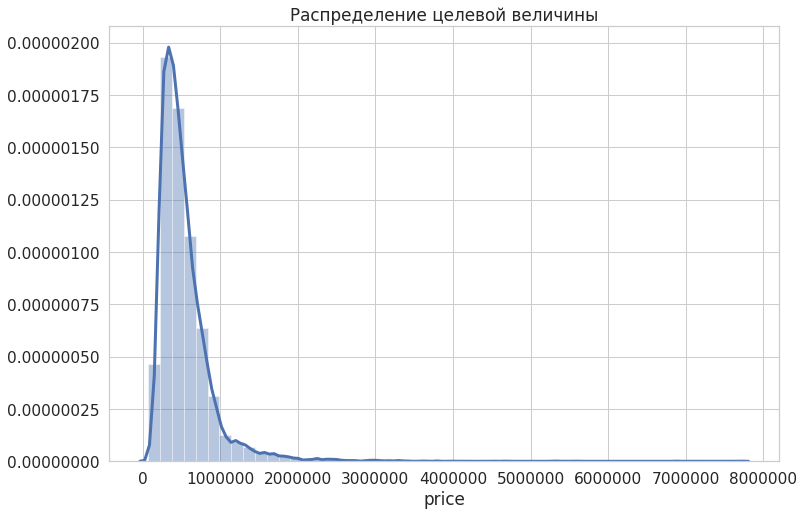

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Распределение целевой величины")
sns.distplot(train_df.price, kde_kws = {"lw": 3});

Распределение очень похоже на нормальное, но перекошено вправо.  
В таких случаях принято логарифмировать, это повышает качество предсказания.

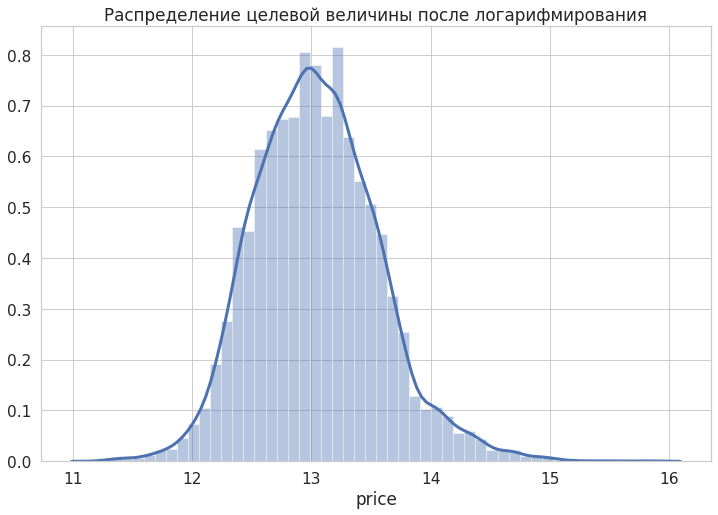

In [6]:
plt.figure(figsize=(12, 8))
train_df.price = train_df.price.apply(np.log)
plt.title("Распределение целевой величины после логарифмирования")
sns.distplot(train_df.price, kde_kws = {"lw": 3});

Выделим из начальных данных полезные признаки (feature engineering). 

Просуммируем такую группу признаков, как:

- `sqft_living`, `sqft_above`, `sqft_basement`

Т.к. это суммарная полезная площадь жилья без учёта приусадебного участка.  

In [7]:
def add_up_useful_space(df):
    df["sqft_living"] += df["sqft_above"] + df["sqft_basement"]
    return df.drop(columns=["sqft_above", "sqft_basement"])

transformer_lst.append(add_up_useful_space)
train_df = train_df.pipe(add_up_useful_space)

Кроме того, районы города `zipcode` неоднородны, потому посчитаем среднюю стоимость жилья в районе `price_by_zipcode`.

In [8]:
zip2price = dict(train_df.price.groupby(train_df.zipcode).mean())


def mean_price_by_zipcode(df):
    df["price_by_zipcode"] = df.zipcode.apply(zip2price.get)
    return df

transformer_lst.append(mean_price_by_zipcode)
train_df = train_df.pipe(mean_price_by_zipcode)

Посмотрим на корреляции между признаками:

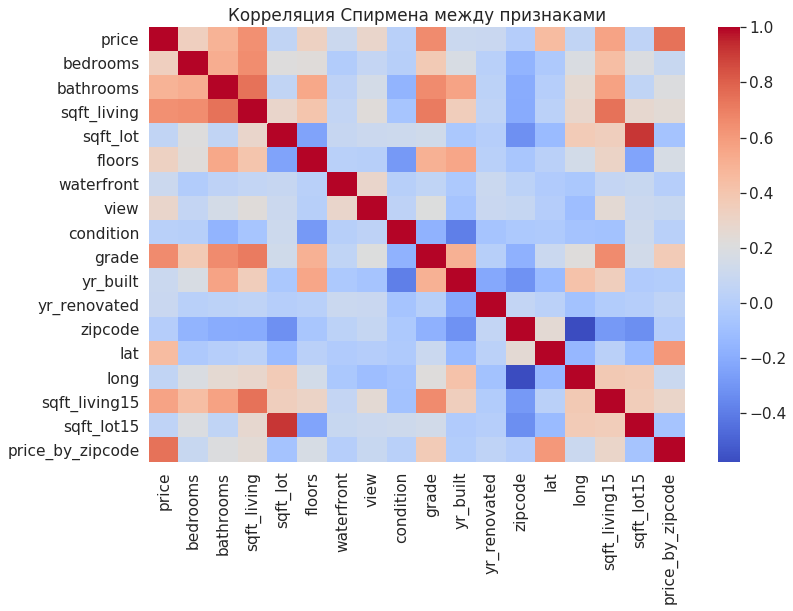

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(method="spearman"), cmap="coolwarm");
plt.title("Корреляция Спирмена между признаками");

Уже отсюда видно положительную корреляцию между `price` и `sqft_living`, `sqft_living15`, `bedrooms`, `bathrooms`, `grade`, `lat`.    


Посмотрим теперь на географическое распределение стоимости жилья, особенно по широте.

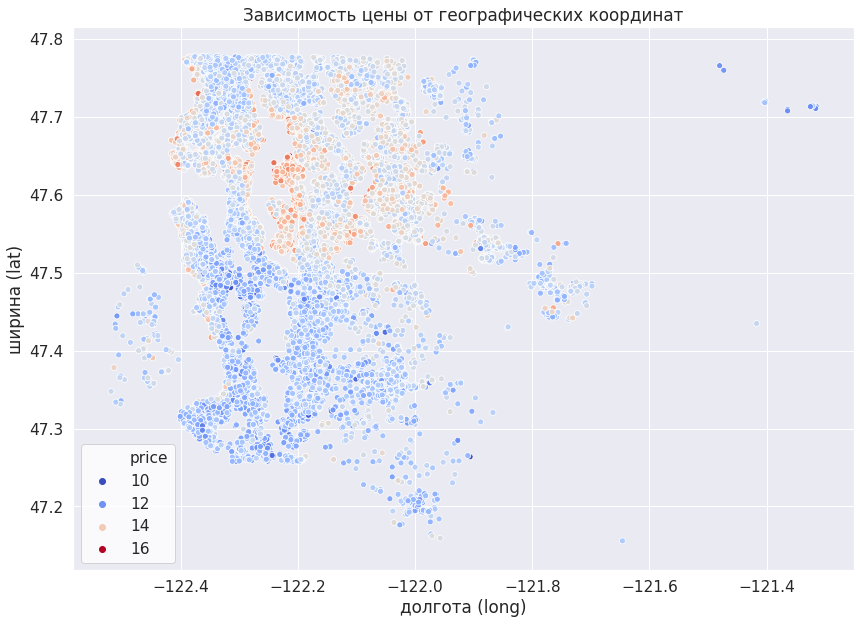

In [10]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(14, 10))
plt.title("Зависимость цены от географических координат")
ax = sns.scatterplot(x="long", y="lat", 
                     data=train_df, 
                     hue="price", 
                     palette="coolwarm");
plt.title
plt.legend().get_frame().set_facecolor("white")
ax.set(xlabel='долгота (long)', ylabel='ширина (lat)');

Чётко видно, что примерно по широте в 47.5 пролегает черта, над которой жильё сильно дороже, чем под ней.  
По долготе таких закономерностей не наблюдается. Посмотрим на совместное распределение цены и широты.

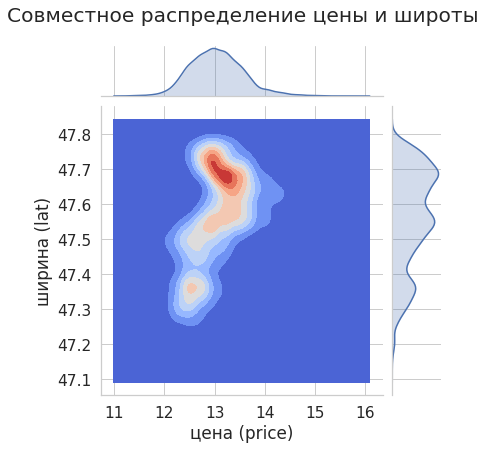

In [11]:
sns.set(font_scale=1.4, style="whitegrid")
g = sns.jointplot(x="price", y="lat", data=train_df, kind="kde", cmap="coolwarm")
g.set_axis_labels(xlabel='цена (price)', ylabel='ширина (lat)');
g.fig.suptitle("Совместное распределение цены и широты", y = 1.05);

Построим аналогичный график, сделав окрашивание по средней цене дома в районе `zipcode`:

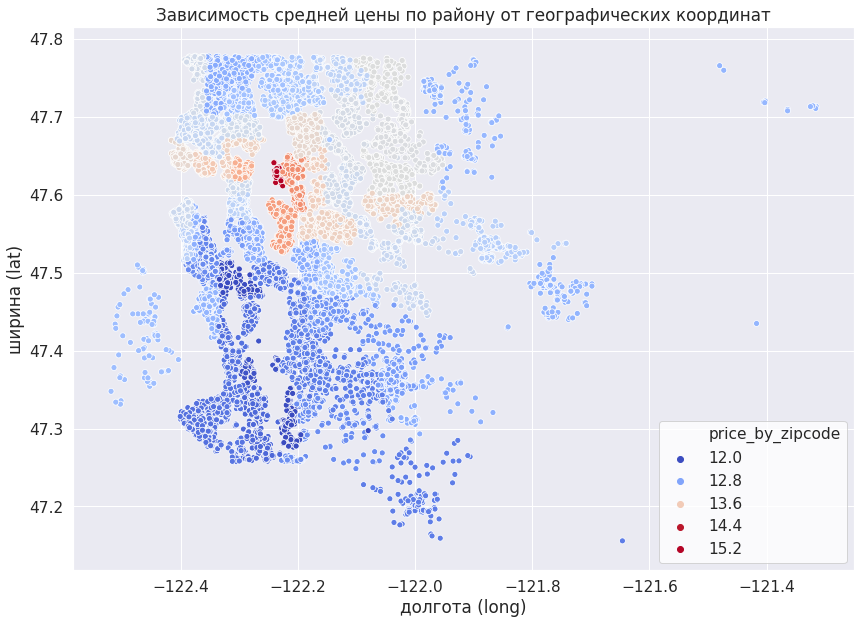

In [12]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(14, 10))
plt.title("Зависимость средней цены по району от географических координат")
ax = sns.scatterplot(x="long", y="lat", 
                     data=train_df, 
                     hue="price_by_zipcode", 
                     palette="coolwarm");
plt.legend().get_frame().set_facecolor("white")
ax.set(xlabel='долгота (long)', ylabel='ширина (lat)');

Ярко выделяется группа районов с существенно более высокой средей ценой жилья. Их стоит сделать отдельными признаками.  


Так как география играет очень важное значение в распределении цены, добавим такие признаки, как расстояние до (центроида) самого дорогого района `dist_to_luxury` и лучшего дома там `dist_to_best_home`. Аналогично для самого дешевого района `dist_to_borough` и для самого дешевого дома `dist_to_worst_home`.

In [13]:
luxurious_zipcode = train_df["price"].groupby(train_df["zipcode"]).mean().argmax()
borough_zipcode = train_df["price"].groupby(train_df["zipcode"]).mean().argmin()
luxurious_centroid = train_df[["lat", "long"]][train_df["zipcode"] == luxurious_zipcode].mean(axis=0).values
borough_centroid = train_df[["lat", "long"]][train_df["zipcode"] == borough_zipcode].mean(axis=0).values
best_home =  train_df[["lat", "long"]][train_df.index == train_df["price"].argmax()].values
worst_home =  train_df[["lat", "long"]][train_df.index == train_df["price"].argmin()].values

def compute_distance_to_best(df):
    df["dist_to_luxury"] = np.sqrt(((df[["lat", "long"]] - luxurious_centroid)**2).sum(axis=1))
    df["dist_to_borough"] = np.sqrt(((df[["lat", "long"]] - borough_centroid)**2).sum(axis=1))
    df["dist_to_best_home"]  = np.sqrt(((df[["lat", "long"]] - best_home)**2).sum(axis=1))
    df["dist_to_worst_home"]  = np.sqrt(((df[["lat", "long"]] - worst_home)**2).sum(axis=1))
    return df

transformer_lst.append(compute_distance_to_best)
train_df = train_df.pipe(compute_distance_to_best)

Посмотрим на среднюю цену `price` в зависимости от района `zipcode`:

In [14]:
top_zipcode_df = pd.DataFrame(zip2price.items(), 
                              columns=["zipcode", "price_by_zipcode"])\
                .sort_values(by="price_by_zipcode", ascending=False)
top_zipcode_df.head(20)

,zipcode,price_by_zipcode
24,98039,14.439936
3,98004,13.966140
25,98040,13.896902
48,98112,13.795915
47,98109,13.629784
4,98005,13.564103
53,98119,13.558866
41,98102,13.558683
5,98006,13.546460
43,98105,13.534096


Возьмем первые 13 районов в порядке этой сортировки (т.к. потом происходит скачок в первом знаке после запятой) и добавим отдельными признаками с помощью `one-hot encoding`.

In [15]:
top_zipcode_lst = top_zipcode_df.head(13).zipcode.values

def one_hot_best_zipcodes(df):
    old_zipcode_lst = np.unique(df.zipcode)
    df = pd.get_dummies(df, columns=["zipcode"])
    for zipcode in old_zipcode_lst:
        if zipcode not in top_zipcode_lst:
            df.drop(columns=[f"zipcode_{zipcode}"], inplace=True)
    return df

transformer_lst.append(one_hot_best_zipcodes)
train_df = train_df.pipe(one_hot_best_zipcodes)

Кроме того, можно считать, что присутствует корреляция между возрастом здания `yr_built` и его **стоимостью**.  
Также стоит отметить, что чем меньше **лет прошло с момента последнего ремонта** `yr_renovated`, тем лучше состояние квартиры.

Создадим новые признаки:

* `yr_published` - год продажи дома
* `mnth_published` - месяц продажи дома
* `age` - число лет с моменты постройки до продажи
* `yr_since_renovation` - число лет с момента последнего ремонта до продажи
* `new_building` - бинарный признак, дом считается новым, если ему менее $10$ лет

In [16]:
def extract_from_date(df):
    df["yr_published"] = df["date"].apply(lambda s: int(s.split("T")[0][:4]))
    df["mnth_published"] = df["date"].apply(lambda s: int(s.split("T")[0][4:6]))
    df["age"] = df["yr_published"] - df["yr_built"] + 1
    df["yr_since_renovation"] = df["yr_published"] - df["yr_renovated"] + 1
    df["yr_since_renovation"][df["yr_renovated"] == 0] = 0
    df["new_building"] = df["age"] <= 10
    return df.drop(columns=["date", "yr_built", "yr_renovated", "yr_published"])

transformer_lst.append(extract_from_date)
train_df = train_df.pipe(extract_from_date)

 Кроме того, спрос на жильё (и, как следствие, предложение на рынке) имеет сезонность, которую можно учесть. Посмотрим, есть ли зависимость между месяцем/годом и ценой.

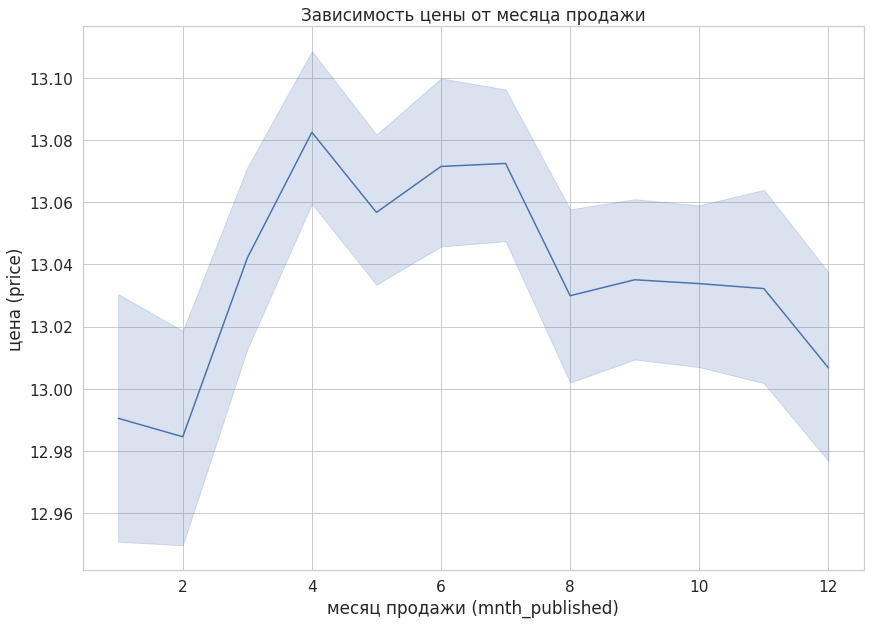

In [17]:
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.4, style="whitegrid")
plt.title("Зависимость цены от месяца продажи")
ax = sns.lineplot(x="mnth_published", y="price", data=train_df)
ax.set(xlabel='месяц продажи (mnth_published)', ylabel='цена (price)');

Видим, что стоимость жилья значимо выше в тёплое время года, с марта по июль. Поэтому добавим бинарный признак тёплого сезона.

In [18]:
def extract_seasonality(df):
    df["warm_season"] = (3 <= df["mnth_published"]) & (df["mnth_published"] <= 7)
    return df.drop(columns=["mnth_published"])

transformer_lst.append(extract_seasonality)
train_df = train_df.pipe(extract_seasonality)

Посмотрим снова на корреляции между признаками:

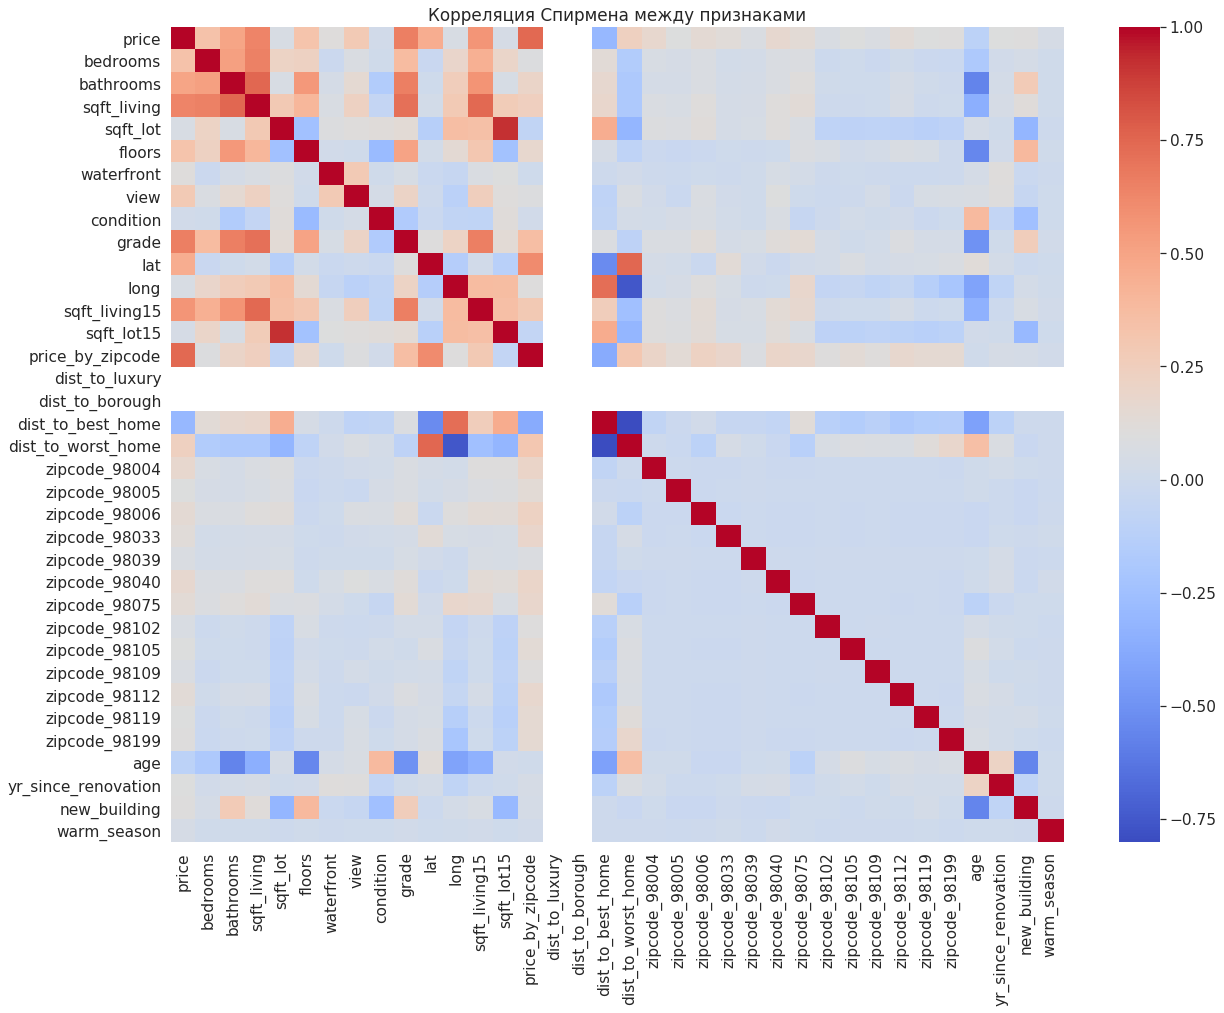

In [19]:
plt.figure(figsize=(20, 15));
sns.heatmap(train_df.corr("spearman"), cmap="coolwarm")
plt.title("Корреляция Спирмена между признаками");

Складывается впечатление, что большая часть добавленных признаков бесполезна: стоимость почти не коррелирует с районом `zipcode` и сезонностью.

### 2. Обучение моделей  и их анализ

Обучим теперь бустинг с параметрами, выбранными "на глаз", чтобы оценить по кросс-валидации текущую ошибку предсказания.  
Кроме того, по результатам бустинга уберём бесполезные признаки.

In [20]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

mape_scorer = make_scorer(mape, greater_is_better=False)

In [21]:
grid_cv = GridSearchCV(xgb.XGBRegressor(gamma=0.1, subsample=0.75, 
                                        n_estimators=1000, max_depth=5, 
                                        nthread=-1), 
                       {}, cv=5, verbose=True, scoring=mape_scorer, n_jobs=5)
grid_cv.fit(train_df.drop(columns=["price"]), train_df.price)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   50.3s remaining:  1.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0.1,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                   

In [22]:
-grid_cv.best_score_

0.950526231638612

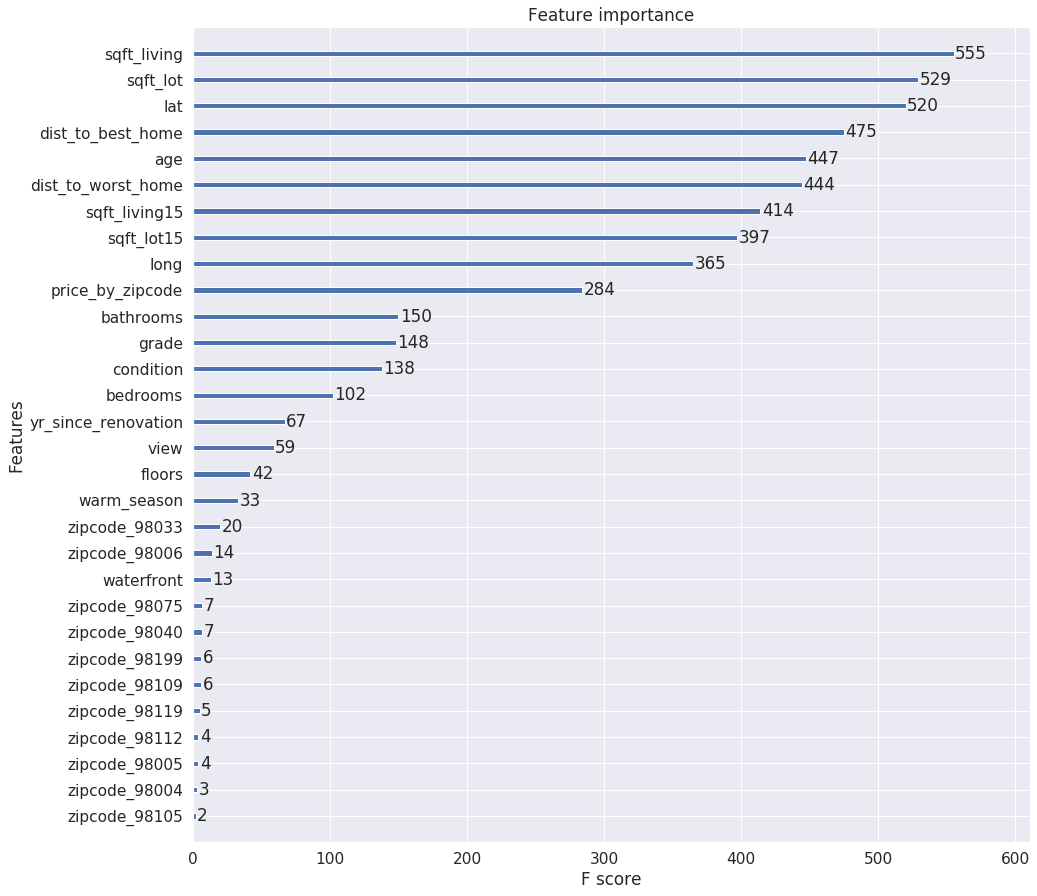

In [23]:
sns.set(style="darkgrid", font_scale=1.4)
fig, ax = plt.subplots(1,1,figsize=(15, 15))
xgb.plot_importance(grid_cv.best_estimator_, ax=ax);

Видно, что **зипкоды** бесполезны (т.к. информация, которую они несут, дублируется другими признаками), потому просто выбросим их.  
Кроме того, **вид на воду** почему-то не вдохновляет покупателей, а **сезонность** оказалась притянутой за уши.  
Важнее всего оказались географические и самые банальные признаки: широта, долгота, расстояние до самого дорогого и до самого плохого района, площадь помещений и участка, а также год постройки и окружение (средняя стоимость жилья в районе, средняя площадь окрестного жилья). 


### 3. Дальнейший анализ признаков

Удалим незначимые признаки:

In [24]:
def remove_redundant_features(df):
    init_col_lst = df.columns
    for colname in init_col_lst:
        splitted = colname.split("_")
        if splitted[0] == "zipcode" and splitted[1] != top_zipcode_lst[0]:
            df.drop(columns=[colname], inplace=True)
    df.drop(columns=["warm_season", "waterfront", "new_building"], inplace=True)
    return df

transformer_lst.append(remove_redundant_features)
train_df = train_df.pipe(remove_redundant_features)

In [25]:
train_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'price_by_zipcode', 'dist_to_luxury', 'dist_to_borough',
       'dist_to_best_home', 'dist_to_worst_home', 'age',
       'yr_since_renovation'],
      dtype='object')

Чтобы учесть вклад самых значимых признаков в модель, дополним датасет взаимодействиями (произведениями признаков):

In [26]:
def add_interactions(df):
    for xcolname in ["sqft_living", "lat"]:
        for ycolname in ["bedrooms", "floors", "bathrooms", "condition", "grade"]:
            df["{}_x_{}".format(xcolname, ycolname)] = df[xcolname] * df[ycolname]
    return df

transformer_lst.append(add_interactions)
train_df = train_df.pipe(add_interactions)

Посмотрим на распределение оставшихся признаков:

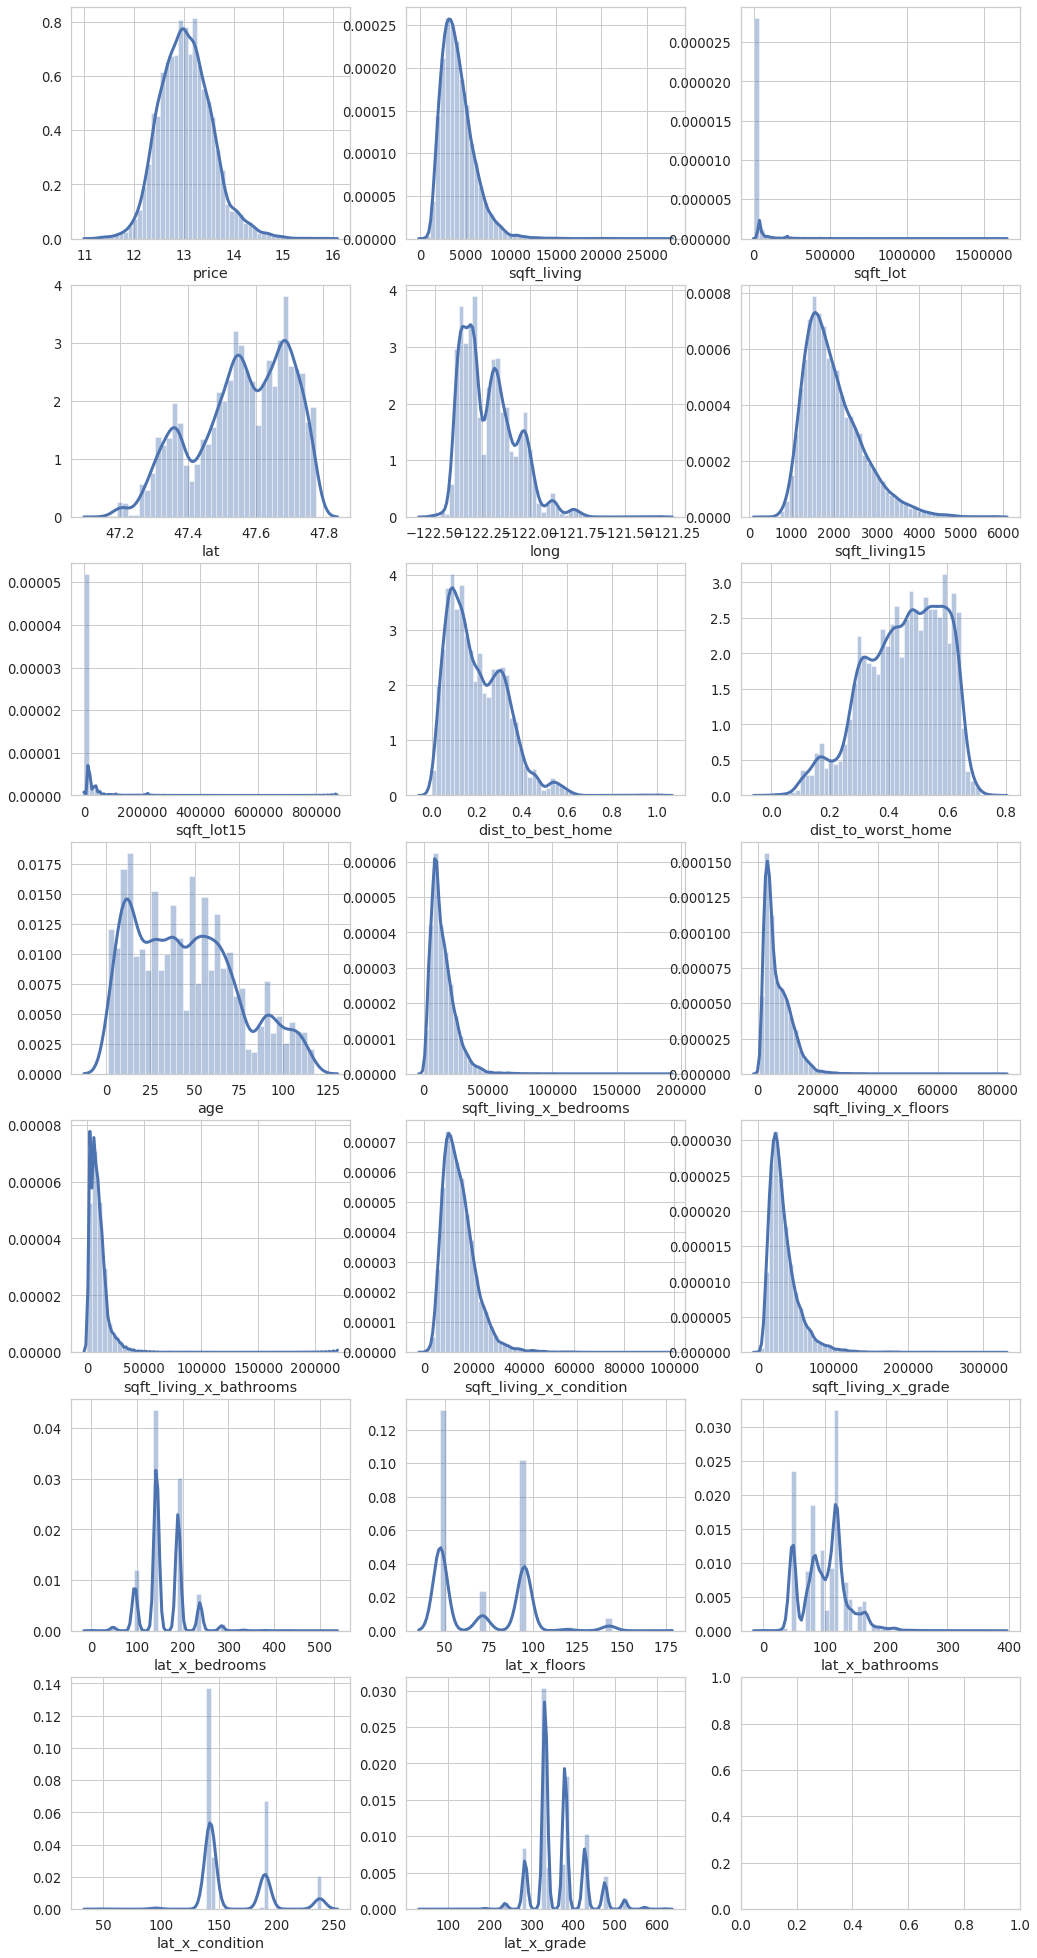

In [27]:
sns.set(font_scale=1.2, style="whitegrid")
f, axes = plt.subplots(7, 3, figsize=(17, 35))
i = 0
for feature in train_df.columns:
    if len(np.unique(train_df[feature])) > 100:
        sns.distplot(train_df[feature], kde_kws = {"lw": 3}, ax = axes[i // 3][i % 3])
        i += 1  
plt.show()

От некоторых из оставшихся фичей уместно взять логарифм, чтобы сделать их более похожими на нормально распределённые.

In [28]:
def take_logs(df):
    for colname in ["sqft_living", "sqft_lot", "sqft_living15", "sqft_lot15"]:
        df[colname] = np.log(df[colname] + 1)
    return df

transformer_lst.append(take_logs)
train_df = train_df.pipe(take_logs)

Видно, что корреляции остались отчётливо выраженными.

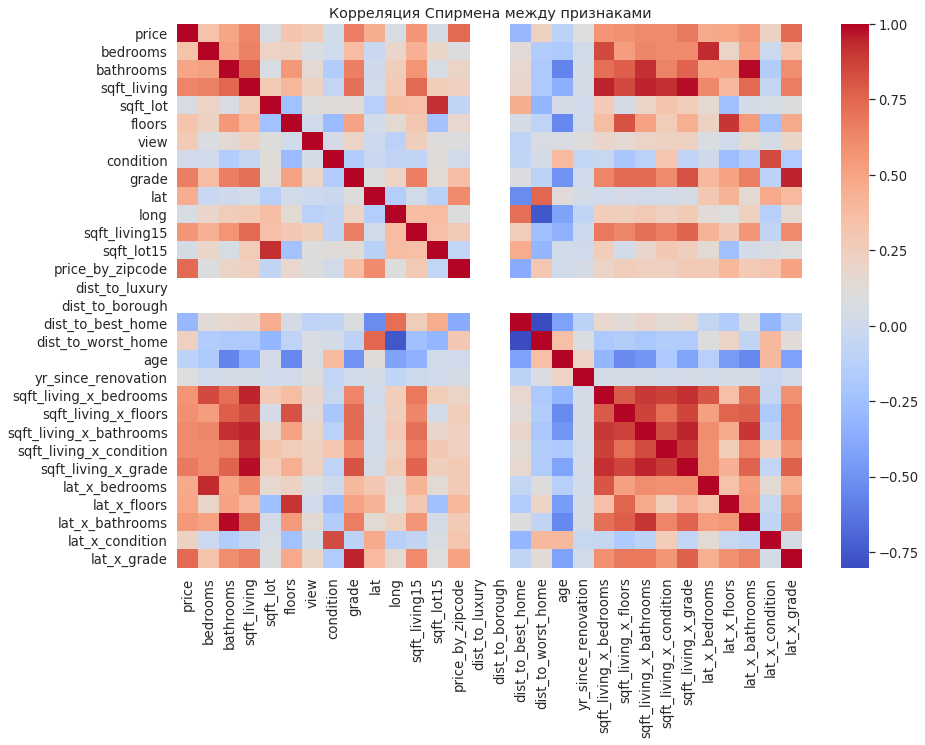

In [29]:
plt.figure(figsize=(14, 10));
sns.heatmap(train_df.corr("spearman"), cmap="coolwarm")
plt.title("Корреляция Спирмена между признаками");

Посмотрим на зависимость целевой переменной `price` от признаков:

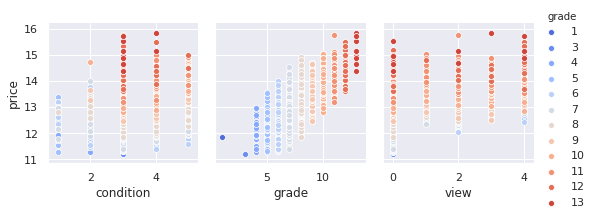

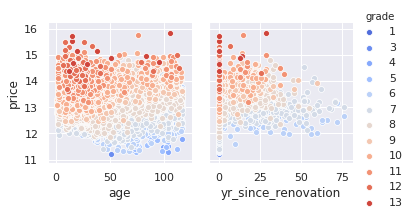

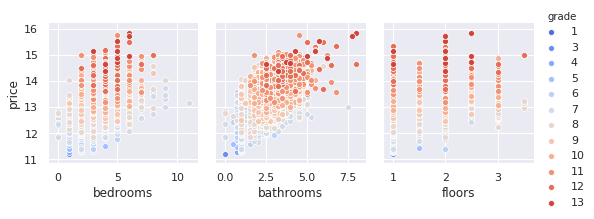

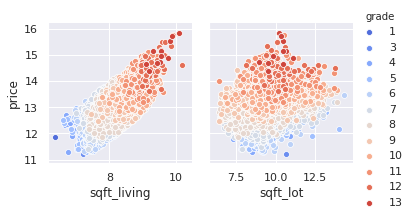

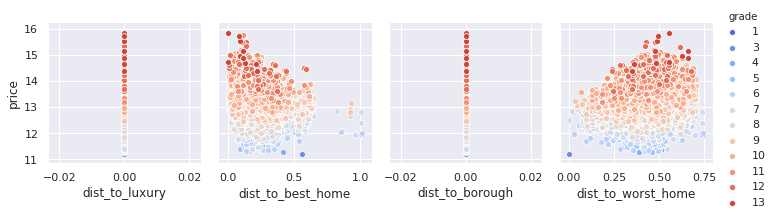

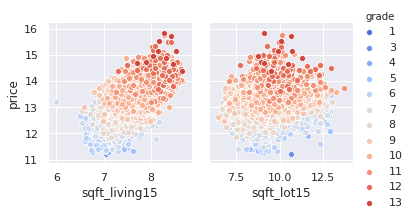

In [30]:
sns.set()

f_chunk_lst = [["condition", "grade", "view"], 
               ["age",  "yr_since_renovation"], 
               ["bedrooms", "bathrooms", "floors"], 
               ["sqft_living", "sqft_lot"], 
               ["dist_to_luxury", "dist_to_best_home", "dist_to_borough", "dist_to_worst_home"],
               ["sqft_living15", "sqft_lot15"]]

for chunk in tqdm_notebook(f_chunk_lst):
    sns.pairplot(x_vars=chunk, 
                 y_vars=["price"], 
                 data=train_df, 
                 hue="grade", 
                 palette="coolwarm");

Чуть-чуть текста о неудачных экспериментах:

Мне казалось, что у меня есть секретное оружие: `UMAP`, статья 2018 года, `t-SNE` + `transform`.  
Планировалось с его помощью понизить размерность таким образом, чтобы точки, максимально похожие друг на друга по совокупности значимых параметров, оказались рядом. 

Я рассчитывал получить хорошее приближение значений на тесте, но не судьба. 

In [ ]:
import umap

useful_column_lst = ["sqft_living", 
                     "condition", 
                     "grade", 
                     "lat", "long", 
                     "price_by_zipcode",
                     "dist_to_luxury", 
                     "dist_to_best_home", 
                     "dist_to_borough", 
                     "dist_to_worst_home"]

umap_prj = umap.UMAP(verbose=True)
umap_prj.fit(train_df[useful_column_lst], train_df.price)

In [ ]:
def add_embedding(df):
    embedding = umap_prj.transform(df[useful_column_lst])
    df["umap_x"] = embedding[:, 0]
    df["umap_y"] = embedding[:, 1]
    return df

transformer_lst.append(add_embedding)
train_df = train_df.pipe(add_embedding)

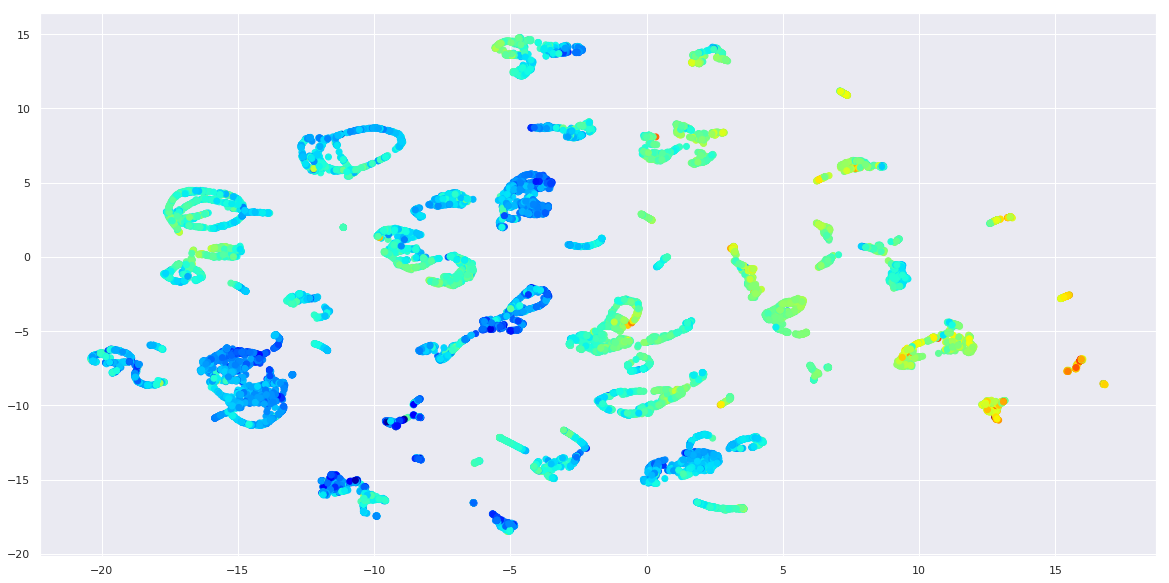

In [43]:
plt.figure(figsize=(20,10))
plt.scatter(umap_prj.embedding_[:, 0], 
            umap_prj.embedding_[:, 1], 
            c=train_df.price, 
            cmap="jet")

Показательно, как явственно очерчены кластеры домов, подобных по цене.  
Тем не менее, добавление этой информации в модель ничего не давало, когда я пробовал (тут не стал).

In [44]:
test_df = pd.read_csv("houses_test.csv").drop(columns=["id"])
for f in tqdm_notebook(transformer_lst, "transformer map"):
    test_df = test_df.pipe(f)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs



In [45]:
assert np.all(np.sort(train_df.drop(columns=["price"]).columns) == np.sort(test_df.columns))

In [46]:
test_df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'price_by_zipcode', 'dist_to_luxury', 'dist_to_borough',
       'dist_to_best_home', 'dist_to_worst_home', 'age', 'yr_since_renovation',
       'sqft_living_x_bedrooms', 'sqft_living_x_floors',
       'sqft_living_x_bathrooms', 'sqft_living_x_condition',
       'sqft_living_x_grade', 'lat_x_bedrooms', 'lat_x_floors',
       'lat_x_bathrooms', 'lat_x_condition', 'lat_x_grade', 'umap_x',
       'umap_y'],
      dtype='object')

### 4. Финальное обучение

In [47]:
scaler = StandardScaler()
grid_cv = GridSearchCV(
    xgb.XGBRegressor(gamma=0.1, subsample=0.75, 
                     n_estimators=1000, max_depth=5, 
                     nthread=-1), 
    {}, cv=5, verbose=True, scoring=mape_scorer, n_jobs=5
)

grid_cv.fit(scaler.fit_transform(train_df.drop(columns=["price"])), train_df.price)
y_pred = np.exp(grid_cv.predict(scaler.transform(test_df)))
-mape_scorer(grid_cv, scaler.transform(train_df.drop(columns=["price"])), train_df.price)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/common/ivanov.vv/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/common/ivanov.vv/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   27.5s finished
/home/common/ivanov.vv/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
/home/common/ivanov.vv/anaconda3/envs/py37/lib

0.6082375676466303

Усредняем полученные .csv-файлы, в лучших традициях Kaggle.

In [48]:
submission_df = pd.DataFrame((y_pred + pd.read_csv("answer_20190407-1546-47.csv")["price"]) / 2 , 
                             columns=["price"])
submission_df.index += 1
submission_df.to_csv(f'answer_{datetime.now():%Y%m%d-%H%M-%S}.csv', index=True, index_label="index")

Ещё чуть-чуть о неудачных попытках:

### 5. Что ещё я пробовал:

1. **Стекинг** (случайные леса + lasso-регрессия + kNN). То ли я обучил слишком мало моделей (я брал 4 леса, 2 регрессии и 1 kNN), то ли он просто не должен был здесь сработать. Я делал его грамотно: для каждой модели бил данные на 10 фолдов, обучал на 9, предсказывал 10, а также параллельно с этим предсказывал на тесте и потом усреднял предсказания по фолдам. Поверх этого я обучал бустинг, но он не справился нормально предсказать. MAPE был порядка 14.
2. **Нейросети**. Я накидал пару сеток на keras, но соотношение данные/фичи было слишком печальным, они не обучались. Структура была стандартная: (Dense, BatchNorm, ReLU, Dropout), 3-4 таких блока.  
3. **Ансамблирование**. В какой-то момент я психанул и решил обучить все известные мне простые модели в большом количестве, а потом усреднить их предсказания, уповая на УЗБЧ. Вышло неплохо, но мой лучший результат не переплюнуло.

**Вывод:**

грамотный feature engineering и подбор гиперпараметров градиентного бустинга помогли мне достичь самого лучшего результата.